# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from utils import tools, preprocessing, models, eval, plotting

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.2.3
Numpy version: 1.26.4
Tensorflow version: 2.16.2


In [3]:
config = tools.load_config('config.yaml')

In [4]:
# paths
data = 'pvod'
key = 'station04.csv'

# model params
model_name = 'tcn-gru'
output_dim = 48 # in hours
make_callbacks = False

# data params
freq = '1h'
lookback = 48 # in hours
horizon = 48 # in hours
# data split params
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
#study_name = f'fl_d_{data}_m-{model_name}_out-{output_dim}_freq-{freq}'

In [5]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon

In [6]:
# read data
#df = preprocessing.preprocess_1b_trina(path=path,
#                                       freq=freq)
known, observed, static = preprocessing.get_features(data=data)
real_features = known + observed
dfs = preprocessing.get_data(data=data, data_dir='../../Data', freq=freq, rel_features=real_features)
df = dfs[key]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8352 entries, 2018-06-30 16:00:00 to 2019-06-13 15:00:00
Freq: h
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nwp_gti            8352 non-null   float64
 1   nwp_temperature    8352 non-null   float64
 2   nwp_humidity       8352 non-null   float64
 3   nwp_windspeed      8352 non-null   float64
 4   lmd_gti            8352 non-null   float64
 5   lmd_temperature    8352 non-null   float64
 6   lmd_pressure       8352 non-null   float64
 7   lmd_winddirection  8352 non-null   float64
 8   lmd_windspeed      8352 non-null   float64
 9   power              8352 non-null   float64
dtypes: float64(10)
memory usage: 717.8 KB


In [8]:
prepared_data, _ = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static,
                                           test_start=pd.Timestamp(config['data']['test_start']))
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [9]:
hyperparameters = tools.get_hyperparameters(config=config)

config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

2025-04-23 19:38:42.898072: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-23 19:38:42.898096: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-23 19:38:42.898104: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-23 19:38:42.898122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 19:38:42.898135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
#model.summary()

In [11]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = hyperparameters['shuffle']
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/10


2025-04-23 19:38:43.394416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0542 - mae: 0.1627 - rmse: 0.2305 - val_loss: 0.0486 - val_mae: 0.1468 - val_rmse: 0.2204
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0342 - mae: 0.1238 - rmse: 0.1843 - val_loss: 0.0449 - val_mae: 0.1379 - val_rmse: 0.2118
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0299 - mae: 0.1132 - rmse: 0.1724 - val_loss: 0.0417 - val_mae: 0.1317 - val_rmse: 0.2042
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0286 - mae: 0.1099 - rmse: 0.1688 - val_loss: 0.0395 - val_mae: 0.1284 - val_rmse: 0.1988
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0278 - mae: 0.1076 - rmse: 0.1664 - val_loss: 0.0383 - val_mae: 0.1269 - val_rmse: 0.1958
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0266 - mae: 0.1045 - rmse: 0.1625 - val_loss: 0.0374 - val_mae: 0.1265 - val_rmse: 0.1935
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0259 - mae: 0.1032 - rmse: 0.

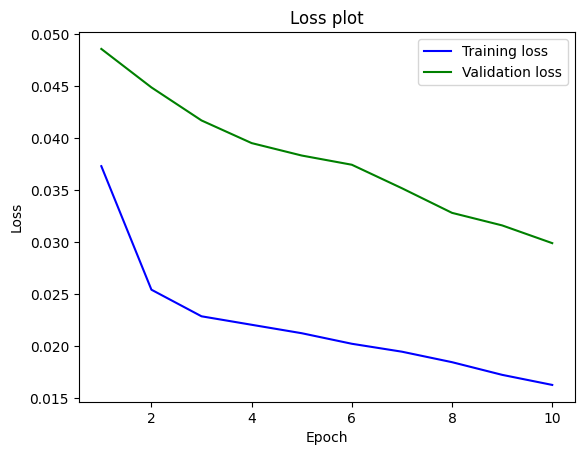

In [12]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [13]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

y_pers = eval.persistence(y=df['power'],
                    horizon=horizon,
                    from_date=str(index_test[0].date()))
y_pers = preprocessing.make_windows(data=y_pers,
                                    seq_len=y_pred.shape[-1])
df_pers = tools.y_to_df(y=y_pers,
                    output_dim=output_dim,
                    horizon=horizon,
                    index_test=index_test,
                    t_0=None if evaluate_on_all_test_data else t_0)

pers = {}
pers['Persistence'] = df_pers

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [14]:
results = eval.evaluate_models(pred=df_pred,
                               true=df_true,
                               persistence=pers,
                               main_model_name=model_name)

In [15]:
results

,R^2,RMSE,MAE,Skill
Models,,,,
tcn-gru,0.801692,0.170744,0.106201,0.281525
Persistence,0.615836,0.237647,0.116752,0.000000


R^2: 0.8067495371611715
RMSE: 0.15335674924353984
MAE: 0.09534374492542745


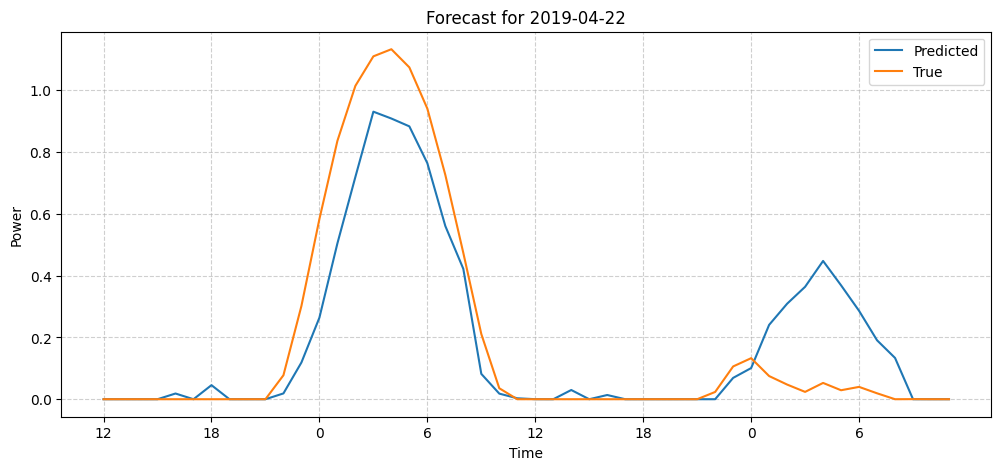

In [16]:
#date = '2018-06-06'
date = plotting.random_date(start_date=str(index_test[0].date()),
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

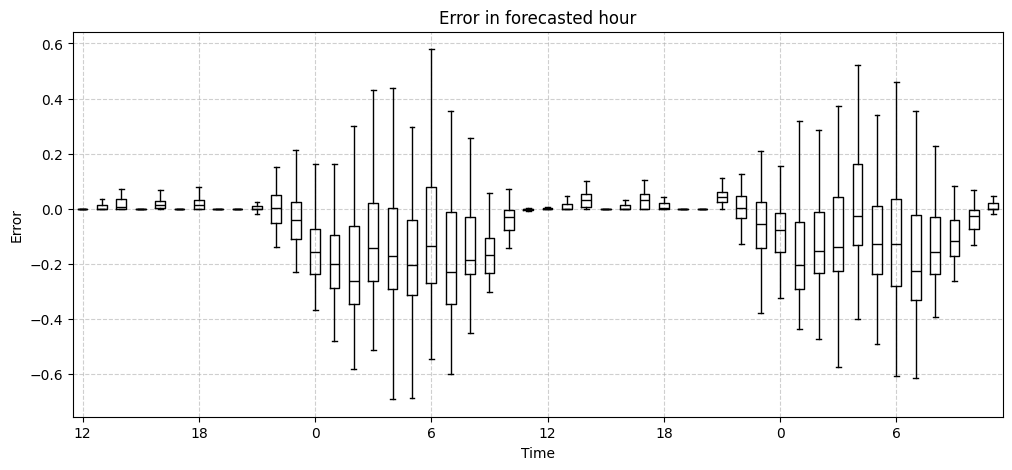

In [17]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

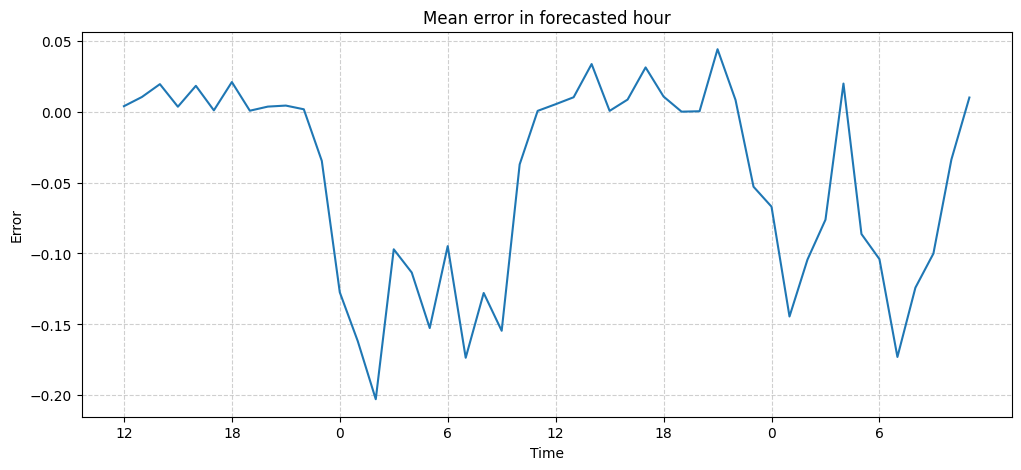

In [18]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

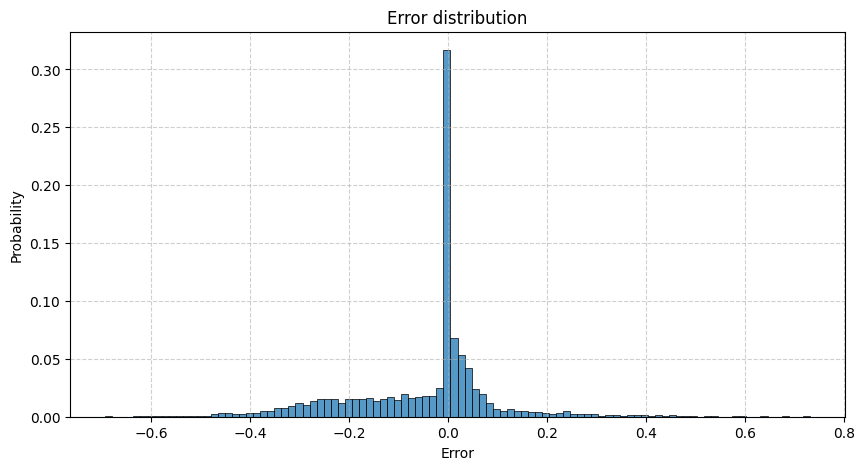

In [19]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)